# Testing JAM using Analytic Solutions for Hernquist Models

[<img src="https://users.physics.ox.ac.uk/~cappellari/images/jam-logo.svg" width="100">](https://users.physics.ox.ac.uk/~cappellari/software/#sec:jam)

This notebook showcases the accuracy of the `jampy` package by reproducing classic analytic results for spherical dynamical models. It applies the Jeans Anisotropic Modelling (JAM) method ([Cappellari 2008](https://ui.adsabs.harvard.edu/abs/2008MNRAS.390...71C/abstract), [2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.494.4819C/abstract)) to a density profile described by a Multi-Gaussian Expansion (MGE). The MGE is fitted to an analytic profile using the `mgefit` package ([Cappellari 2002](https://ui.adsabs.harvard.edu/abs/2002MNRAS.333..400C/abstract)).

Since analytic solutions are generally available only for spherical models, all tests are restricted to this case or to axisymmetric models in their spherical limit. More general axisymmetric tests are described in the JAM paper ([Cappellari 2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.494.4819C/abstract)).

- **V1.0.0**: Michele Cappellari, Oxford, 28 November 2008
- **V1.1.0**: Included test with anisotropy and black holes. MC, Oxford, 17 June 2010
- **V2.0.0**: Translated from IDL into Python. MC, Oxford, 9 April 2014
- **V2.0.1**: Fixed RuntimeWarning. MC, Oxford, 17 March 2017
- **V2.0.2**: Changed imports for jam as a package. MC, Oxford, 17 April 2018
- **V2.1.0**: Use the new jampy.jam_axi_proj. MC, Oxford, 28 April 2021
- **V2.2.0**: Included align='sph' models and plot legend. MC, Oxford, 30 April 2021
- **V2.2.1**: Adapted for new jam_sph_proj. MC, Oxford, 3 October 2022
- **V2.3.0**: Added Osipkov-Merritt test. MC, Oxford, 1 June 2023
- **V2.4.0**: Expanded documentation and converted to Notebook format. MC, Oxford, 30 July 2025

## 1. Imports

First, I import the necessary libraries and set up the plotting environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mgefit as mge
import jampy as jam

## 2. MGE Fit to the Hernquist Density Profile

I define the physical parameters for our model galaxy. I assume a total mass `M`, a scale radius `a`, and place it at the distance of the Virgo cluster.

In [2]:
M = 1e11          # Total mass in Solar Masses
a = 1e3           # Break radius in pc
distance = 16.5   # Assume Virgo distance in Mpc (Mei et al. 2007)
pc = distance*np.pi/0.648 # Constant factor to convert arcsec --> pc
G = 0.004301      # (km/s)^2 pc/Msun [6.674e-11 SI units (CODATA2018)]
mbh = 0           # Start with no black hole

The `jampy` package operates on Multi-Gaussian Expansion (MGE) models. I first need to approximate the analytic Hernquist density profile with a sum of Gaussians. I use the `mgefit` package [(Cappellari 2002)](https://ui.adsabs.harvard.edu/abs/2002MNRAS.333..400C/abstract) for this purpose.

> **Note**: When a profile is known analytically, one should not make the mistake of generating a 2D image and fitting it with a 2D MGE. Instead, one should directly fit the 1D analytic profile with 1D Gaussians, as done here. This approach is significantly faster and more accurate. For maximum speed, one can also use the `linear=True` keyword in `mge.fit_1d`, which provides a major speed-up at the cost of a slightly less optimal fit for a given number of Gaussians.

The [Hernquist (1990, hereafter H90)](https://ui.adsabs.harvard.edu/abs/1990ApJ...356..359H/abstract) density profile is given by:
$$ \rho(r) = \frac{M a}{2\pi r (r+a)^3} $$

Iteration: 0  chi2: 0.1294  Nonzero: 16/16
Iteration: 10  chi2: 0.009284  Nonzero: 16/16
Iteration: 18  chi2: 0.008831  Nonzero: 16/16
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.34 seconds
  Total Iterations:  18
 Nonzero Gaussians:  16
  Unused Gaussians:  0
 Chi2: 0.008831 
 STDEV: 0.005425
 MEANABSDEV: 0.004835
############################################
  Total_Counts       Sigma
############################################
   2.6647e+04         2.351
   2.6093e+04         5.367
   2.5764e+04         12.13
   2.5140e+04         27.05
   2.3776e+04         58.97
   2.0851e+04         123.6
   1.5591e+04         245.4
   9.0270e+03         462.1
   3.8897e+03         837.5
   1.2912e+03         1484.
   3.5314e+02         2595.
   8.4859e+01         4506.
   1.8829e+01         7789.
   4.0021e+00     1.346e+04
   8.3838e-01     2.373e+04
   1.5537e-01     4.831e+04
############################################

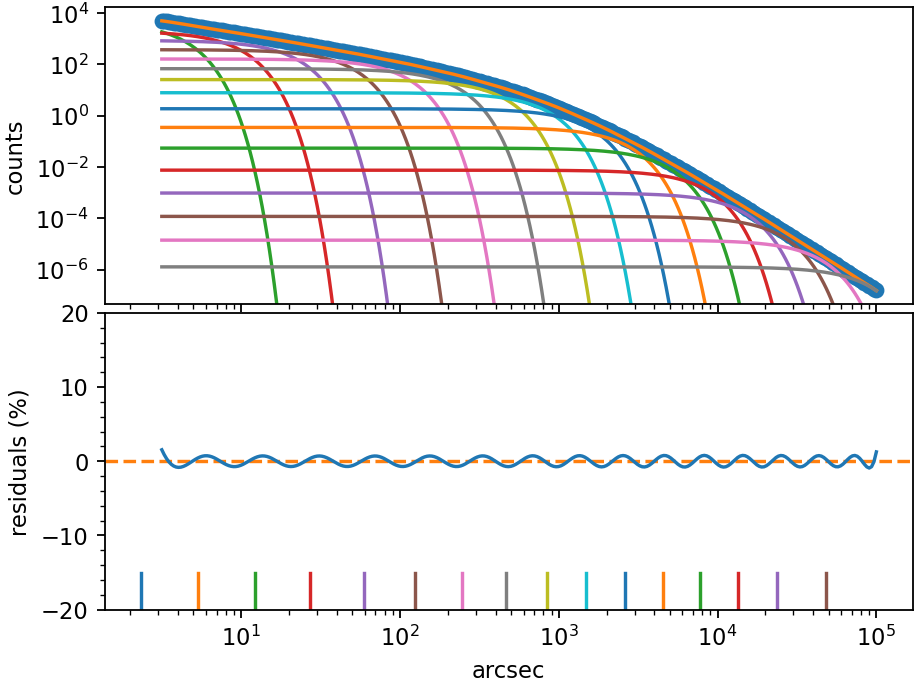

In [3]:
n = 300  # Number of values to sample the H90 profile for the fit
r_fit = np.logspace(-2.5, 2, n)*a       # logarithmically spaced radii in pc
rho = M*a/(2*np.pi*r_fit*(r_fit + a)**3)    # Density in Msun/pc**3 (H90 equation 2)

m = mge.fit_1d(r_fit, rho, ngauss=16, plot=True)
plt.pause(1)

## 3. Prepare Inputs for JAM

I extract the MGE parameters from the fit. For a fit to the 3D density, `m.sol[0]` contains the surface densities of the Gaussians and `m.sol[1]` contains their dispersions. See the documentation of [mge.fit_1d](https://pypi.org/project/mgefit/#returns-1) to understand this step. I also define the radii where I want to compute the kinematics.

In [4]:
# When fitting the intrinsic density, m.sol[0] represents the projected
# surface density. See the docstring of `mge.fit_1d` for an explanation
surf = m.sol[0]                 # Surface density in Msun/pc**2
sigma = m.sol[1]/pc             # Gaussian dispersion in arcsec
qObs = np.ones_like(surf)       # Assume spherical model
inc = 90                        # Edge-on view
npix = 100
rad = np.geomspace(0.1, 100, npix) # desired output radii in arcsec (avoid R=0)
r = rad*pc # radii in pc

## 4. Circular Velocity $V_{\rm circ}$

I compute the circular velocity from the MGE model and compare it to the analytic solution from H90, eq. (16):
$$ V_{\rm circ}(r) = \frac{\sqrt{GMr}}{r+a} $$

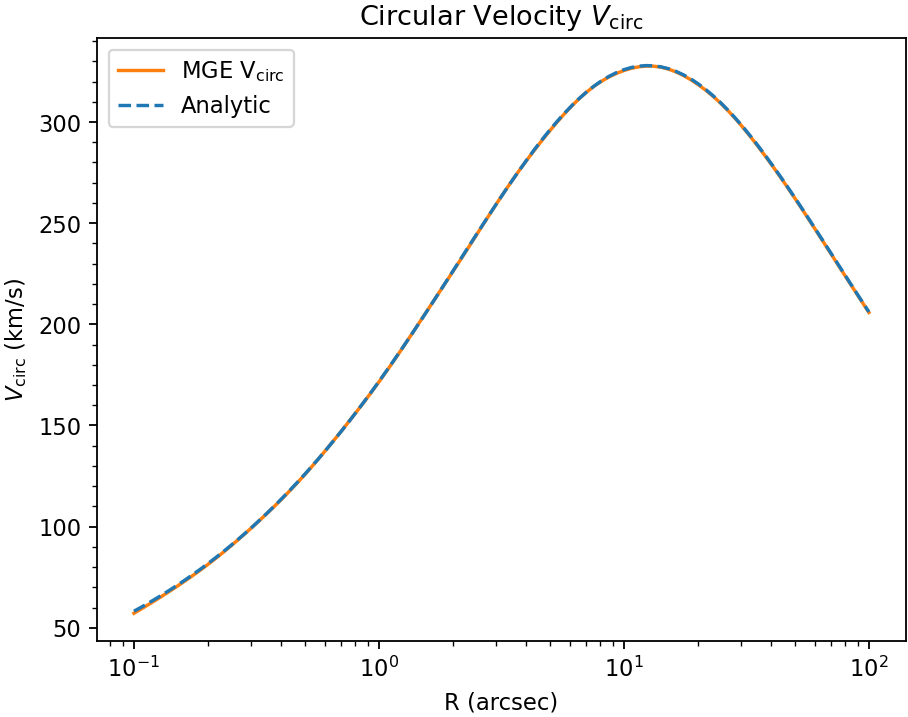

In [5]:

plt.xlabel('R (arcsec)')
plt.ylabel(r'$V_{\rm circ}$ (km/s)')
plt.title(r'Circular Velocity $V_{\rm circ}$')

# MGE calculation
vcirc = jam.mge.vcirc(surf, sigma, qObs, inc, mbh, distance, rad)
plt.plot(rad, vcirc, 'C1', label=r'MGE V$_{\rm circ}$')

# Analytic solution
vc_analytic = np.sqrt(G*M*r)/(r + a)
plt.plot(rad, vc_analytic, 'C0--', label='Analytic')
plt.xscale('log')
plt.legend();

## 5. Isotropic Projected $V_{\rm rms}$ 

I compute the projected velocity dispersion ($V_{\rm rms}$) for a spherical, isotropic model and compare it to the analytic solution from H90, eq. (41). I test three different `jampy` implementations, which should all yield the same result in this limit:
- A standard spherical model.
- An axisymmetric model with a cylindrically-aligned velocity ellipsoid.
- An axisymmetric model with a spherically-aligned velocity ellipsoid.

jam_sph_proj elapsed time sec: 0.03 (quad1d)
No PSF convolution: sigmapsf == 0; pixsize == 0;
Total mass MGE (MSun): 9.841e+10; BH: 0.0; beta[0]=0.00068

jam.axi.proj(align='cyl', moment='zz') -- elapsed time sec: 0.10
analytic_los=1 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0 interp=0
inc=90.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.841e+10

jam.axi.proj(align='sph', moment='zz') -- elapsed time sec: 0.96
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0 interp=0
inc=90.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.841e+10



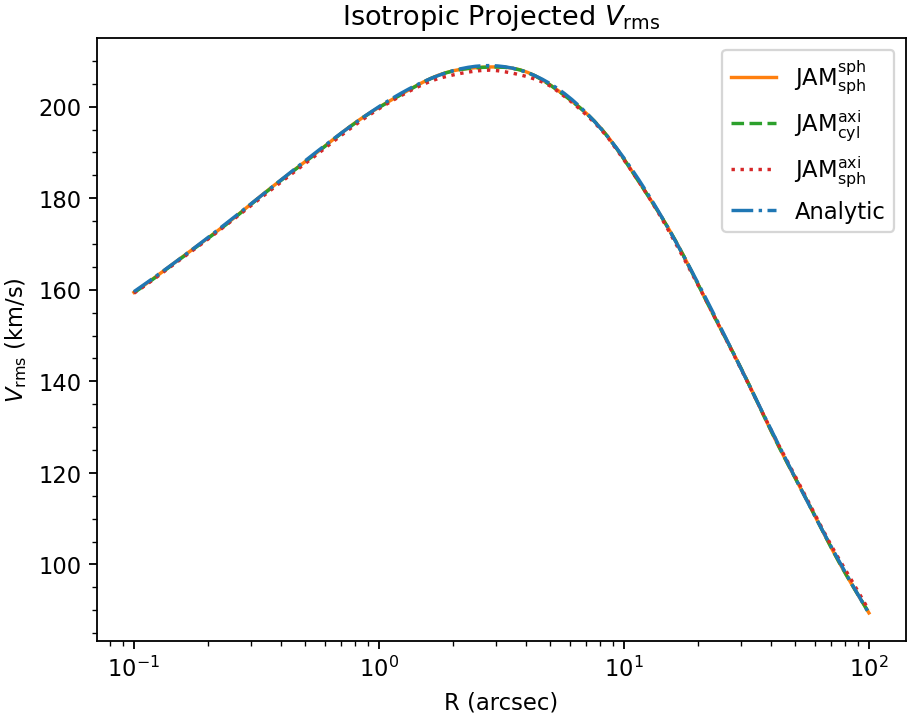

In [6]:
plt.xlabel('R (arcsec)')
plt.ylabel(r'$V_{\rm rms}$ (km/s)')
plt.title(r'Isotropic Projected $V_{\rm rms}$')

# Spherical isotropic H90 model
out_sph = jam.sph.proj(surf, sigma, surf, sigma, mbh, distance, rad)
plt.semilogx(rad, out_sph.model, 'C1', label=r'JAM$^{\rm sph}_{\rm sph}$')

# Axisymmetric isotropic model (cylindrical alignment) in the spherical limit
vrms_cyl = jam.axi.proj(surf, sigma, qObs, surf, sigma, qObs,
                        inc, mbh, distance, rad, rad*0, align='cyl').model
plt.plot(rad, vrms_cyl, 'C2--', label=r'JAM$^{\rm axi}_{\rm cyl}$')

# Axisymmetric isotropic model (spherical alignment) in the spherical limit
vrms_sph = jam.axi.proj(surf, sigma, qObs, surf, sigma, qObs,
                        inc, mbh, distance, rad, rad*0, align='sph').model
plt.plot(rad, vrms_sph, 'C3:', label=r'JAM$^{\rm axi}_{\rm sph}$')

# Analytic solution for Vrms
s = r/a
w = s < 1
xs = np.hstack([np.arccosh(1/s[w]) / np.sqrt(1 - s[w]**2),    # H90 eq. (33)
                np.arccos(1/s[~w]) / np.sqrt(s[~w]**2 - 1)])  # H90 eq. (34)
IR = M*((2 + s**2)*xs - 3) / (2*np.pi*a**2*(1 - s**2)**2)     # H90 eq. (32)

sigp_analytic = np.sqrt(G*M**2/(12*np.pi*a**3*IR) # H90 equation (41)
             *(0.5/(1 - s**2)**3
             *(-3*s**2*xs*(8*s**6 - 28*s**4 + 35*s**2 - 20)
             - 24*s**6 + 68*s**4 - 65*s**2 + 6) - 6*np.pi*s))
plt.plot(rad, sigp_analytic, 'C0-.', label='Analytic')
plt.legend();

## 6. Anisotropic Projected $V_{\rm rms}$ (Fully Tangential Limit)

This section tests the `jampy` predictions for a model with tangentially biased orbits ($\sigma_r=0$, or $\beta \to -\infty$). I approximate this extreme case using $\beta = -20$ to maintain numerical stability and compare the results to the analytic solution from H90, eq. (42). The fact that I cannot use $\beta = -\infty$ directly explains the small disagreement wit the analytic solution.

I test three different `jampy` implementations, which should all agree in this spherical limit:
- A standard spherical model.
- An axisymmetric model with a spherically-aligned velocity ellipsoid.
- An axisymmetric model with a cylindrically-aligned velocity ellipsoid. In the spherical limit, this model's major-axis $V_{\rm rms}$ should equal the spherical $V_{\rm rms}$ after division by $\sqrt{2}$.

jam_sph_proj elapsed time sec: 0.05 (quad1d)
No PSF convolution: sigmapsf == 0; pixsize == 0;
Total mass MGE (MSun): 9.841e+10; BH: 0.0; beta[0]=-20.

jam.axi.proj(align='cyl', moment='zz') -- elapsed time sec: 0.13
analytic_los=1 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0 interp=0
inc=90.0; beta[0]=-20.; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.841e+10

jam.axi.proj(align='sph', moment='zz') -- elapsed time sec: 1.19
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0 interp=0
inc=90.0; beta[0]=-20.; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.841e+10



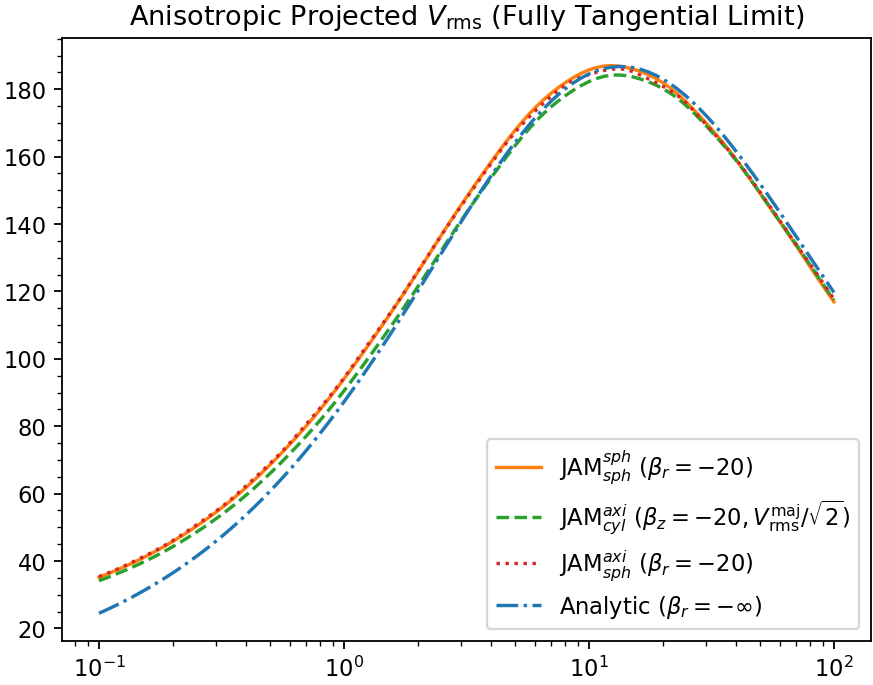

In [7]:
beta = np.full_like(surf, -20) 
out = jam.sph.proj(surf, sigma, surf, sigma, mbh, distance, rad, beta=beta)
plt.semilogx(rad, out.model, 'C1', label='JAM$^{sph}_{sph}$ ($\\beta_r=-20$)')

# Axisymmetric anisotropic model in the spherical limit.
# The spherical Vrms is the same as the Vrms/sqrt(2) on the major axis of the cylindrically-aligned model in the spherical limit.

vrms_maj = jam.axi.proj(surf, sigma, qObs, surf, sigma, qObs,
                        inc, mbh, distance, rad, rad*0, beta=beta, align='cyl').model
vrms_r = jam.axi.proj(surf, sigma, qObs, surf, sigma, qObs,
                      inc, mbh, distance, rad, rad*0, beta=beta, align='sph').model
plt.plot(rad, vrms_maj/np.sqrt(2), 'C2--', label=r'JAM$^{axi}_{cyl}\ (\beta_z=-20, V^{\rm maj}_{\rm rms}/\sqrt{2})$')
plt.plot(rad, vrms_r, 'C3:', label=r'JAM$^{axi}_{sph}\ (\beta_r=-20)$')

# Projected second moments of fully tangential model from H90
#
sigp = np.sqrt(G*M**2*r**2/(2*np.pi*a**5*IR) # H90 equation (42)
                 *(1./(24*(1 - s**2)**4)
                 *(-xs*(24*s**8 - 108*s**6 + 189*s**4 - 120*s**2 + 120)
                 - 24*s**6 + 92*s**4 - 117*s**2 + 154) + 0.5*np.pi/s))
plt.plot(rad, sigp, 'C0-.', label=r'Analytic ($\beta_r=-\infty$)')
plt.title(r'Anisotropic Projected $V_{\rm rms}$ (Fully Tangential Limit)')
plt.legend();

## 7. Osipkov-Merritt Anisotropy with Black Hole - Projected $V_{\rm rms}$

Here I test the Osipkov-Merritt anisotropy model ([Osipkov 1979](https://ui.adsabs.harvard.edu/abs/1979PAZh....5...77O/abstract), [Merritt 1985](https://ui.adsabs.harvard.edu/abs/1985AJ.....90.1027M/abstract)), which describes a system that is isotropic ($\beta=0$) at the center and becomes fully radially anisotropic ($\beta=1$) at large radii. In this example, I also include a central black hole with a mass equal to 0.5% of the galaxy stellar mass.

I compare three models of increasing numerical complexity:
- A spherical model using the analytic Osipkov-Merritt solution for the intrinsic dispersion, requiring only a single line-of-sight numerical quadrature.
- A spherical model using a general logistic function for the anisotropy, with parameters chosen so the logistic profile reduces to the Osipkov-Merritt case. This requires a two-dimensional numerical quadrature.
- An axisymmetric model, in the spherical limit, using the same logistic anisotropy profile. This approach requires a full three-dimensional numerical quadrature.

jam_sph_proj elapsed time sec: 0.05 (quad1d)
No PSF convolution: sigmapsf == 0; pixsize == 0;
Total mass MGE (MSun): 9.841e+10; BH: 5.0e+08; beta[0]=0.00068

jam_sph_proj elapsed time sec: 0.21 (quad2d)
No PSF convolution: sigmapsf == 0; pixsize == 0;
Total mass MGE (MSun): 9.841e+10; BH: 5.0e+08; beta[1]=0.0

jam.axi.proj(align='sph', moment='zz') -- elapsed time sec: 1.28
analytic_los=0 logistic=1 constant_anisotropy=0
No PSF/pixel convolution because sigmapsf=0 pixsize=0 interp=0
inc=90.0; beta[1]=0.0; kappa=1.00; M/L=1.00; BH=5.0e+08; chi2/DOF=nan
Total mass MGE (MSun): 9.841e+10



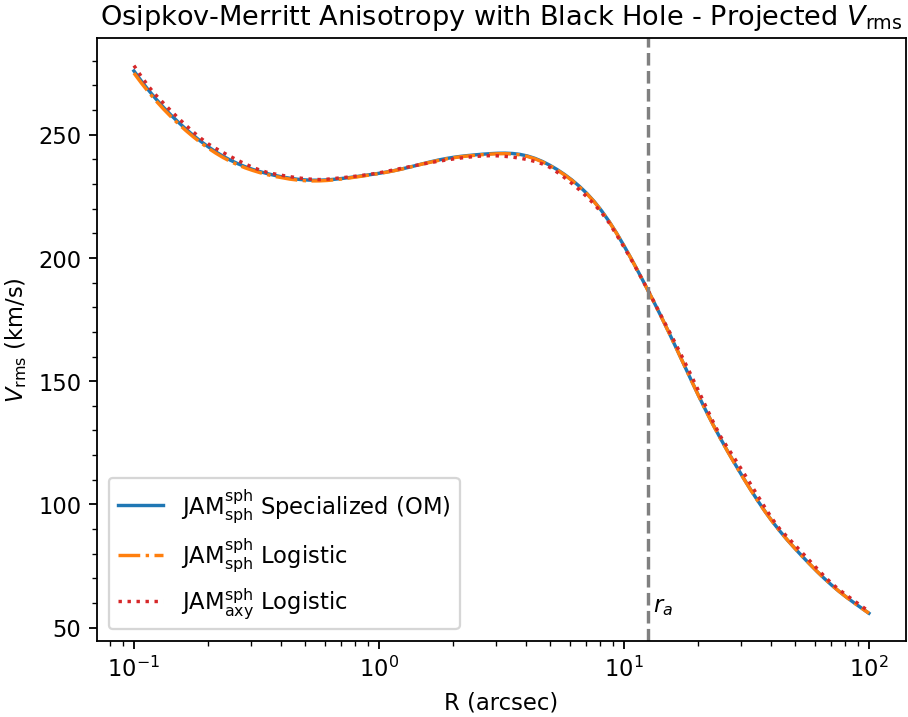

In [8]:
plt.xlabel('R (arcsec)')
plt.ylabel(r'$V_{\rm rms}$ (km/s)')
plt.title(r'Osipkov-Merritt Anisotropy with Black Hole - Projected $V_{\rm rms}$')

beta0 = 0       # Isotropic in the centre
betainf = 1     # Fully radial at infinity
ra_anisotropy = a/pc       # anisotropy radius in arcsec
alpha = 2       # Osipkov-Merritt exponent
beta_om = [ra_anisotropy, beta0, betainf, alpha]
mbh_om = 0.005*M

# Specialized Osipkov-Merritt analytic solution
sigp_om_analytic = jam.sph.proj(surf, sigma, surf, sigma, mbh_om, distance, rad, rani=ra_anisotropy).model
plt.semilogx(rad, sigp_om_analytic, 'C0', label=r'JAM$^{\rm sph}_{\rm sph}$ Specialized (OM)')

# Generic logistic anisotropy with Osipkov-Merritt values
sigp_om_logistic = jam.sph.proj(surf, sigma, surf, sigma, mbh_om, distance, rad, beta=beta_om, logistic=1).model
plt.plot(rad, sigp_om_logistic, 'C1-.', label=r'JAM$^{\rm sph}_{\rm sph}$ Logistic')

# Axisymmetric model in the spherical limit with logistic anisotropy
vrms_om_axi = jam.axi.proj(surf, sigma, qObs, surf, sigma, qObs, inc, mbh_om,
                           distance, rad, rad*0, beta=beta_om, align='sph', logistic=1).model
plt.plot(rad, vrms_om_axi, 'C3:', label=r'JAM$^{\rm sph}_{\rm axy}$ Logistic')
plt.axvline(ra_anisotropy, ls='--', c='grey')
plt.text(ra_anisotropy*1.05, np.min(vrms_om_axi), r'$r_a$')
plt.legend();

## 8. Constant-Anisotropy Models with Black Hole - Projected $V_{\rm rms}$

In this final section, I reproduce the bottom panel of Figure 4.20 from [Binney & Tremaine (2008)](https://ui.adsabs.harvard.edu/abs/2008gady.book.....B/abstract). This figure shows the effect of a central black hole on the projected velocity dispersion for models with different constant anisotropies ($\beta$).

I test three different `jampy` implementations, which should all yield the same result in this limit:
- A standard spherical model.
- An axisymmetric model with a spherically-aligned velocity ellipsoid.
- An axisymmetric model with a cylindrically-aligned velocity ellipsoid (for the isotropic case).

jam_sph_proj elapsed time sec: 0.04 (quad1d)
No PSF convolution: sigmapsf == 0; pixsize == 0;
Total mass MGE (MSun): 9.841e+10; BH: 0.0; beta[0]=-0.51

jam.axi.proj(align='sph', moment='zz') -- elapsed time sec: 0.97
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0 interp=0
inc=90.0; beta[0]=-0.51; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.841e+10

jam_sph_proj elapsed time sec: 0.02 (quad1d)
No PSF convolution: sigmapsf == 0; pixsize == 0;
Total mass MGE (MSun): 9.841e+10; BH: 2.0e+08; beta[0]=-0.51

jam.axi.proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0 interp=0
inc=90.0; beta[0]=-0.51; kappa=1.00; M/L=1.00; BH=2.0e+08; chi2/DOF=nan
Total mass MGE (MSun): 9.841e+10

jam_sph_proj elapsed time sec: 0.02 (quad1d)
No PSF convolution: sigmapsf == 0; pixsize == 0;
Total mass MGE (MSun): 9.841e+10; BH: 

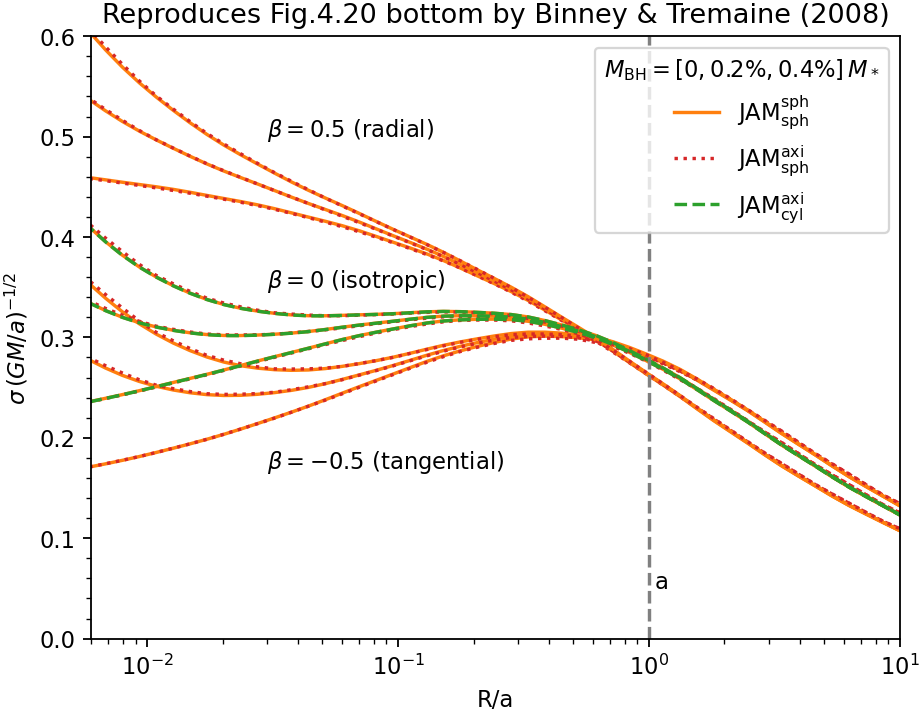

In [9]:
plt.xlabel('R/a')
plt.ylabel(r'$\sigma\, (G M / a)^{-1/2}$')
plt.title('Reproduces Fig.4.20 bottom by Binney & Tremaine (2008)')

cost = np.sqrt(G*M/a)
rad_bt = np.logspace(-2.3, 1, 50)*a/pc # desired output radii in arcsec
bhs = np.array([0., 0.002, 0.004])*M
betas = np.array([-0.51, 0, 0.51]) # Avoids singularity at beta=+/-0.5

# Test anisotropic models with a Black Hole
# I loop over different anisotropies (beta) and black hole masses (mbh)
for i, beta in enumerate(betas):
    betaj = np.full_like(surf, beta)
    for j, bh in enumerate(bhs):
        # For the legend, only label the first plotted line
        label_sph = r'JAM$^{\rm sph}_{\rm sph}$' if i == 0 and j == 0 else None
        label_axi = r'JAM$^{\rm axi}_{\rm sph}$' if i == 0 and j == 0 else None

        # Spherical JAM
        out = jam.sph.proj(surf, sigma, surf, sigma, bh, distance, rad_bt, beta=betaj)
        plt.semilogx(rad_bt/a*pc, out.model/cost, 'C1', label=label_sph)

        # Axisymmetric JAM (spherical alignment)
        vrms = jam.axi.proj(surf, sigma, qObs, surf, sigma, qObs,
                            inc, bh, distance, rad_bt, rad_bt*0, beta=betaj, align='sph').model
        plt.plot(rad_bt/a*pc, vrms/cost, 'C3:', label=label_axi)

# Test isotropic models with a Black Hole using cylindrical-aligned JAM
# This should match the beta=0 case above
for j, bh in enumerate(bhs):
    label = r'JAM$^{\rm axi}_{\rm cyl}$' if j == 0 else None
    vrms = jam.axi.proj(surf, sigma, qObs, surf, sigma, qObs,
                        inc, bh, distance, rad_bt, rad_bt*0, align='cyl').model
    plt.plot(rad_bt/a*pc, vrms/cost, 'C2--', label=label)

plt.axvline(1, ls='--', c='grey')
plt.text(1.05, 0.05, 'a')
plt.axis([0.006, 10, 0, 0.6]) # x0, x1, y0, y1
plt.legend(title=r'$M_{\rm BH}=[0, 0.2\%, 0.4\%]\, M_*$')

plt.text(0.03, 0.17, r'$\beta=-0.5$ (tangential)')
plt.text(.03, 0.35, r'$\beta=0$ (isotropic)')
plt.text(0.03, 0.5, r'$\beta=0.5$ (radial)');